<a href="https://colab.research.google.com/github/ghif-A/aero-itb-tasks/blob/main/statistics_project_aero_itb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and Data Prep

**Hello, we are from group 21 AE2204 Data Science and Statistics class 01.**

**In this notebook we will explore and analyze some datasets which contains Aerospace topics.**

**Let's start!**

First, Let's check the python version. *(note: this is optional)*

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


Then, import all libraries that will be used.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt
from matplotlib import colors as c
plt.rcParams.update({'font.size': 13})
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import pi
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import plotly.express as px
from multiprocessing import cpu_count
from multiprocessing.dummy import Pool as ThreadPool
from os import listdir
from os.path import isfile, join
import folium
import folium.plugins as plugins
import warnings
warnings.filterwarnings('ignore')
import time
import requests
import urllib.parse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


And also mount our google drive to import the datasets later.

(note: if you dont have the datasets, you can download it from [here](https://drive.google.com/drive/folders/1oYvZpixshLCVsGIWcq2K9Oy_WDXCk7Oy?usp=sharing))

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


To check or make sure the drive is mounted, run this code below.

In [ ]:
!ls drive/MyDrive

The output should be match with the list of the folders and files in your google drive.

Then, copy the dataset into colab virtual disk.

In [ ]:
!cp '/content/drive/MyDrive/dataset/' -r '/content'

The process may takes 3 - 5 minutes.

After that, import  `'transonic_airfoil_data_set.csv'`.

In [ ]:
data1 = pd.read_csv('/content/dataset/data_set_aerospace/transonic_airfoil_data_set_train.csv',index_col='Unnamed: 0')

Make sure it's the right data. Print the first 5 rows of the data.

In [ ]:
print(data1.head())

          M       aoa        CL        CD        CP
1  0.727928  2.449037  0.740129  0.013330 -0.911550
2  0.736393  2.389265  0.736667  0.015423 -1.218775
3  0.731969  2.251332  0.709717  0.013156 -1.122496
4  0.735015  2.388274  0.736197  0.014977 -1.214580
5  0.725872  2.448004  0.737060  0.012857 -0.697603


This notebook is divided in 4 parts:
1. Transonic Airfoil
2. Subsonic Airfoil
3. Aeroelasticity
4. Aviation

You may just select one of them without run the code in previous/another parts.

# 1. Transonic Airfoil

## Model Training

The data is already imported in previous section. Let's check all variables correlation coefficient.

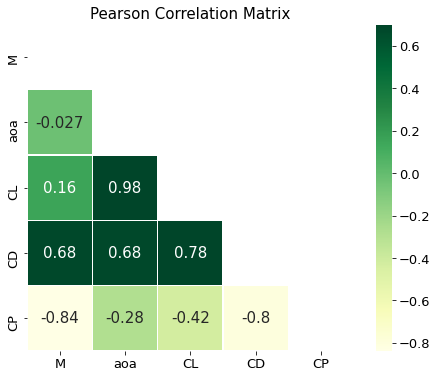

In [ ]:
#@title Pearson Correlation Coefficient (r)
features = ['M', 'aoa', 'CL', 'CD', 'CP']
mask = np.zeros_like(data1[features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 6))
plt.title('Pearson Correlation Matrix', fontsize=15)

sns.heatmap(data1[features].corr(), linewidths=0.25, vmax=0.7, square=True, cmap="YlGn",
            linecolor='w', annot=True, annot_kws={'size':15}, mask=mask)

In [ ]:
#@title Data Manipulation
data1_array = data1.to_numpy()
n_entries1 = data1_array.shape[0]
n_var1 = data1_array.shape[1]-3
print("Five first rows of the data: ")
print(data1_array[:5])

Five first rows of the data: 
[[ 0.727928  2.449037  0.740129  0.01333  -0.91155 ]
 [ 0.736393  2.389265  0.736667  0.015423 -1.218775]
 [ 0.731969  2.251332  0.709717  0.013156 -1.122496]
 [ 0.735015  2.388274  0.736197  0.014977 -1.21458 ]
 [ 0.725872  2.448004  0.73706   0.012857 -0.697603]]


In [ ]:
X1 = data1_array[:,0:2]
y1_cl = data1_array[:,-3].reshape(-1,1)
y1_cd = data1_array[:,-2].reshape(-1,1)
y1_cp = data1_array[:,-1].reshape(-1,1)
print("Five first rows of X (M and AoA): ")
print(X1[:5])
print("Five first rows of y (CL): ")
print(y1_cl[:5].reshape(-1,1))
print("Five first rows of y (CD): ")
print(y1_cd[:5].reshape(-1,1))
print("Five first rows of y (CP): ")
print(y1_cp[:5].reshape(-1,1))

Five first rows of X (M and AoA): 
[[0.727928 2.449037]
 [0.736393 2.389265]
 [0.731969 2.251332]
 [0.735015 2.388274]
 [0.725872 2.448004]]
Five first rows of y (CL): 
[[0.740129]
 [0.736667]
 [0.709717]
 [0.736197]
 [0.73706 ]]
Five first rows of y (CD): 
[[0.01333 ]
 [0.015423]
 [0.013156]
 [0.014977]
 [0.012857]]
Five first rows of y (CP): 
[[-0.91155 ]
 [-1.218775]
 [-1.122496]
 [-1.21458 ]
 [-0.697603]]


In [ ]:
#@title Visualize the data with scatter plot
#This procedure can only be conducted if the number of variables are 1/2
#Function to create scatter plot of the data
def datascatterplot(X,y):
  n_var = X.shape[1]
  if n_var == 1: #Procedure for one variable
      fig = plt.figure(figsize=[8,6])
      plt.scatter(X,y,color='tab:orange')
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.xlabel('x',fontsize=14)
      plt.ylabel('y',fontsize=14)
      plt.grid()
      plt.show()
  elif n_var == 2: #Procedure for two variables
      fig = plt.figure(figsize=[8,6])
      ax = plt.axes(projection='3d')
      ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange')
      ax.set_xlabel('x1',fontsize=14)
      ax.xaxis.labelpad = 10
      ax.set_ylabel('x2',fontsize=14)
      ax.yaxis.labelpad = 10
      ax.set_zlabel('y',fontsize=14)
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.show()
  else:
      print("Your data has more than two variables")

CL

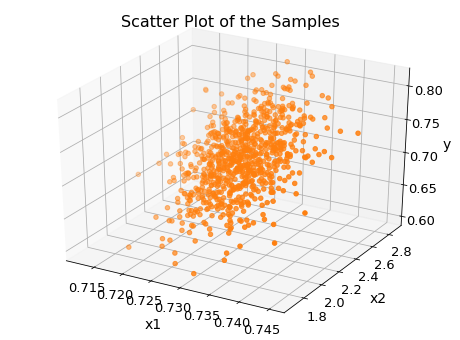

In [ ]:
datascatterplot(X1,y1_cl)

CD

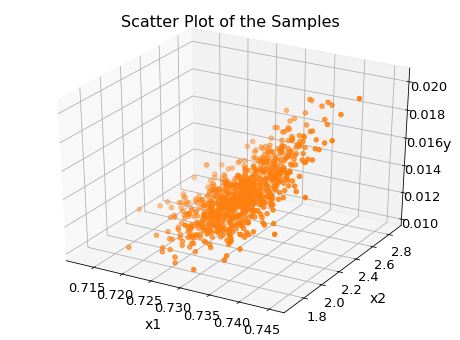

In [ ]:
datascatterplot(X1,y1_cd)

CP

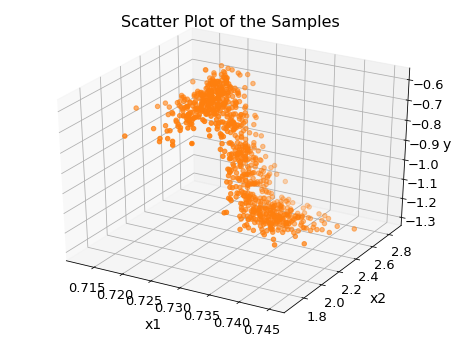

In [ ]:
datascatterplot(X1,y1_cp)

In [ ]:
#@title Linear Regression Model
#Function to train a linear regression model on the data. This function will provede regression coefficeints (beta) and its variances (beta_var).
def LinearRegression(X,y):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X

    #Procedure to obtain regression coefficients by minimizing RSS error
    beta = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@y #Procedure to minimize RSS error
    #Procedure to obtain variances from the regression coefficients
    y_hat = F@beta #Predictions at X
    res_sqr = np.power((y-y_hat),2) #Calculate RSS of the trained linear regression model
    sig_hat_sqr = np.sum(res_sqr)/(n_entries-n_var-1) #Estimate sigma squared
    beta_var = (np.linalg.inv(np.transpose(F)@F)*sig_hat_sqr).diagonal() #Calculate variance of each regression coefficient
    beta_var = beta_var.reshape(-1,1)
    return beta,beta_var

CL

In [ ]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta1_cl, beta_var1_cl = LinearRegression(X1,y1_cl)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var1+1):
    print('beta_{} = {:.4f}'.format(i,beta1_cl[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = -0.6682
beta_1 = 1.3303
beta_2 = 0.1789


CD

In [ ]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta1_cd, beta_var1_cd = LinearRegression(X1,y1_cd)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var1+1):
    print('beta_{} = {:.4f}'.format(i,beta1_cd[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = -0.1614
beta_1 = 0.2216
beta_2 = 0.0056


CP

In [ ]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta1_cp, beta_var1_cp = LinearRegression(X1,y1_cp)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var1+1):
    print('beta_{} = {:.4f}'.format(i,beta1_cp[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = 29.5946
beta_1 = -40.6963
beta_2 = -0.3610


In [ ]:
#@title Summary Matrix
#Function to construct a summary matrix
def summarymat(beta, beta_var, n_entries):
    n_var = beta.shape[0]-1
    beta_std = np.power(beta_var,0.5)
    summary = np.zeros((n_var+1,5))
    summary[:,0] = beta[:,0] #Regression coefficients
    summary[:,1] = beta_std[:,0] #Standard deviation of the regression coefficients
    summary[:,2] = np.divide(beta[:,0],beta_std[:,0]) #t-statistic
    df = n_entries-2 #Degree of freedom
    summary[:,3] = ((np.ones((summary.shape[0],1))-stats.t.cdf(np.abs(summary[:,2]),df).reshape(-1,1)).reshape(-1,))*2 #Calculate p-value based on t-statistic
    #Hypothesis test for 95% confidence interval
    for i in range(n_var+1):
        if summary[i,3]<= 0.05: #If p <= 0.05
            summary[i,4] = 1
        else: #If p > 0.05
            summary[i,4] = 0
    return summary

CL

In [ ]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary1_cl = summarymat(beta1_cl,beta_var1_cl,n_entries1)
print("Summary matrix: ")
print(pd.DataFrame(summary1_cl,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
       Beta  Standard Deviation  t-statistic  p-value  Hypothesis Test
0 -0.668238            0.010463   -63.864906      0.0              1.0
1  1.330334            0.014276    93.184706      0.0              1.0
2  0.178871            0.000359   498.300372      0.0              1.0


CD

In [ ]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary1_cd = summarymat(beta1_cd,beta_var1_cd,n_entries1)
print("Summary matrix: ")
print(pd.DataFrame(summary1_cd,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
       Beta  Standard Deviation  t-statistic  p-value  Hypothesis Test
0 -0.161373            0.001966   -82.081280      0.0              1.0
1  0.221602            0.002682    82.611361      0.0              1.0
2  0.005586            0.000067    82.817887      0.0              1.0


CP

In [ ]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary1_cp = summarymat(beta1_cp,beta_var1_cp,n_entries1)
print("Summary matrix: ")
print(pd.DataFrame(summary1_cp,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
        Beta  Standard Deviation  t-statistic  p-value  Hypothesis Test
0  29.594555            0.572374    51.704883      0.0              1.0
1 -40.696349            0.780957   -52.110860      0.0              1.0
2  -0.360992            0.019636   -18.383873      0.0              1.0


In [ ]:
#@title R2 and RSE
#Calculates the accuracy of the linear regression model in R2 error
#Function to calculates R2 error
def R2_comp(X,y,beta):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X

    #Calculate TSS (Total sum of squares)
    TSS = np.sum(np.power((y-np.mean(y)),2))
    #Calculate RSS (Residual sum of squares)
    y_hat = F@beta #Predictions at each X
    RSS = np.sum(np.power((y-y_hat),2))
    #Calculate R2
    R2 = (TSS-RSS)/TSS
    #Calculate RSE
    RSE = np.sqrt((1/(n_entries-2))*RSS)
    return R2,RSE

CL

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_1_cl, RSE1_cl = R2_comp(X1,y1_cl,beta1_cl)
print("R2-score with the best model: {}".format(R2_1_cl))
print("RSE-score with the best model: {}".format(RSE1_cl))

R2-score with the best model: 0.9968800687750853
RSE-score with the best model: 0.001977860527523616


CD

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_1_cd, RSE1_cd = R2_comp(X1,y1_cd,beta1_cd)
print("R2-score with the best model: {}".format(R2_1_cd))
print("RSE-score with the best model: {}".format(RSE1_cd))

R2-score with the best model: 0.9435531168679956
RSE-score with the best model: 0.00037163187192443427


CP

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_1_cp, RSE1_cp = R2_comp(X1,y1_cp,beta1_cp)
print("R2-score with the best model: {}".format(R2_1_cp))
print("RSE-score with the best model: {}".format(RSE1_cp))

R2-score with the best model: 0.7903072930956674
RSE-score with the best model: 0.10819492114921778


In [ ]:
#@title Visualize the trained linear regression model

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplot(beta,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21))
        x1_vec = x1.reshape(-1,)
        x2_vec = x2.reshape(-1,)
        F_temp = np.ones((21*21,3))
        F_temp[:,1] = x1_vec
        F_temp[:,2] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = F_temp@beta
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix

        fig = plt.figure(figsize=[8,6])
        ax = fig.gca(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='Linear Regression Model')
        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        ax.set_xlabel('x1',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('x2',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('y',fontsize=14)
        plt.title('Linear Regression Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()

    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        F_temp = np.ones((21,2))
        F_temp[:,1] = x1
        #Calculates predictions at the prediction locations
        y_hat = np.matmul(F_temp,beta)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='Linear Regression Model')
        plt.title('Linear Regression Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

CL

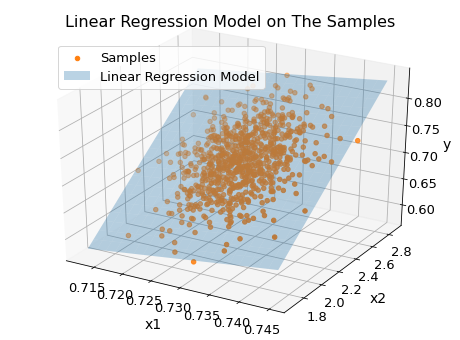

In [ ]:
#To visualize the trained linear regression model, call modelplot function, input: beta,X,y,x1range,x2range
modelplot(beta1_cl,X1,y1_cl)

CD

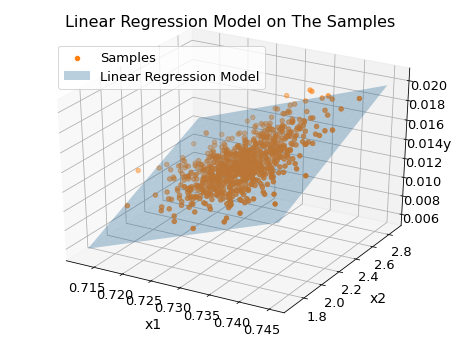

In [ ]:
#To visualize the trained linear regression model, call modelplot function, input: beta,X,y,x1range,x2range
modelplot(beta1_cd,X1,y1_cd)

CP

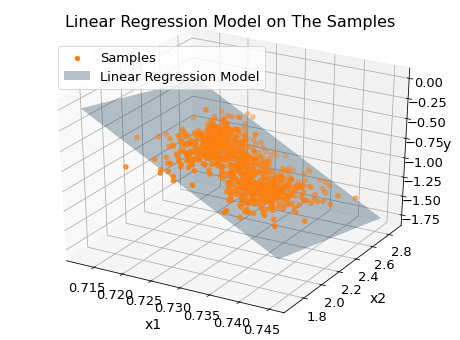

In [ ]:
#To visualize the trained linear regression model, call modelplot function, input: beta,X,y,x1range,x2range
modelplot(beta1_cp,X1,y1_cp)

In [ ]:
#@title KNN plotting and prediction

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplotKNN(knn,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21))

        x1n, x2n = np.meshgrid(np.linspace(0,1,21),np.linspace(0,1,21))
        x1_vec = x1n.reshape(-1,); x2_vec = x2n.reshape(-1,)
        X_temp = np.ones((21*21,2)); X_temp[:,0] = x1_vec; X_temp[:,1] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = knn.predict(X_temp)
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix

        fig = plt.figure(figsize=[8,6])
        ax = fig.gca(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='KNN Model')
        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        ax.set_xlabel('x1',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('x2',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('y',fontsize=14)
        plt.title('KNN Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()

    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        x1n = np.linspace(0,1,21)
        X_temp = np.ones((21,1)); X_temp[:,0] = x1n
        #Calculates predictions at the prediction locations
        y_hat = knn.predict(X_temp)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='KNN Model')
        plt.title('KNN Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

CL

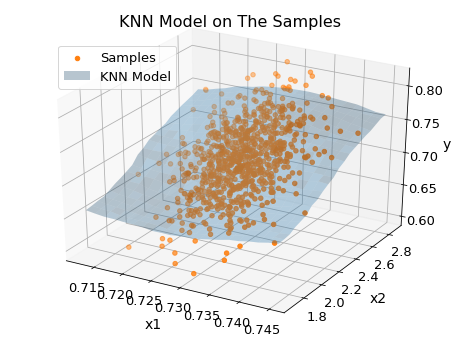

R2 = 0.9417561176257608


In [ ]:
n_neighbors1 = 80 # Number of neighbors

min_max_scaler1 = preprocessing.MinMaxScaler()
X1_norm = min_max_scaler1.fit_transform(X1)
knn1_cl = neighbors.KNeighborsRegressor(n_neighbors1)
knn1_cl.fit(X1_norm, y1_cl)

modelplotKNN(knn1_cl,X1,y1_cl)
print('R2 =', knn1_cl.score(X1_norm,y1_cl))

CD

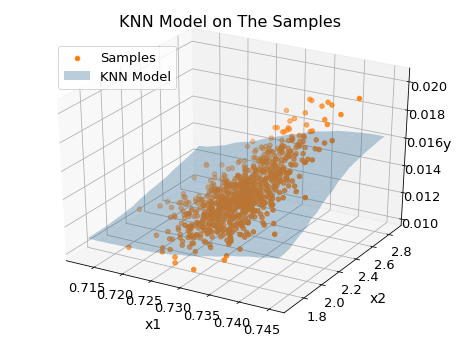

R2 = 0.9191921591760643


In [ ]:
n_neighbors1 = 80 # Number of neighbors

min_max_scaler1 = preprocessing.MinMaxScaler()
X1_norm = min_max_scaler1.fit_transform(X1)
knn1_cd = neighbors.KNeighborsRegressor(n_neighbors1)
knn1_cd.fit(X1_norm, y1_cd)

modelplotKNN(knn1_cd,X1,y1_cd)
print('R2 =', knn1_cd.score(X1_norm,y1_cd))

CP

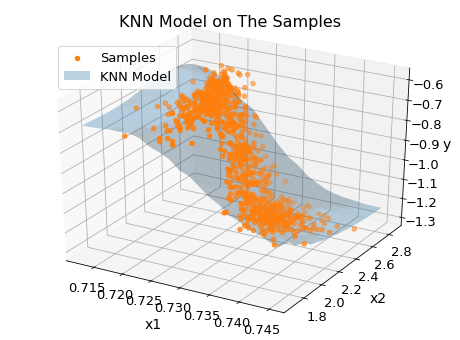

R2 = 0.9683421154028249


In [ ]:
n_neighbors1 = 80 # Number of neighbors

min_max_scaler1 = preprocessing.MinMaxScaler()
X1_norm = min_max_scaler1.fit_transform(X1)
knn1_cp = neighbors.KNeighborsRegressor(n_neighbors1)
knn1_cp.fit(X1_norm, y1_cp)

modelplotKNN(knn1_cp,X1,y1_cp)
print('R2 =', knn1_cp.score(X1_norm,y1_cp))

## Model Testing

In [ ]:
#@title Import data
data1_test = pd.read_csv('/content/dataset/data_set_aerospace/transonic_airfoil_data_set_test.csv',index_col='Unnamed: 0')
data1_test.head()

M       aoa        CL        CD        CP
800  0.716864  2.682617  0.763636  0.012468 -0.648874
801  0.738410  2.254417  0.715570  0.015070 -1.199548
802  0.727162  2.257598  0.703626  0.012166 -0.668080
803  0.731201  2.326171  0.721882  0.013414 -1.120704
804  0.729784  2.219883  0.701254  0.012482 -0.902390

In [ ]:
#@title Data Manipulation
data1_test_array = data1_test.to_numpy()
n_entries1_test = data1_test_array.shape[0]
n_var1_test = data1_test_array.shape[1]-3
print("Five first rows of the data: ")
print(data1_test_array[:5])

Five first rows of the data: 
[[ 0.716864  2.682617  0.763636  0.012468 -0.648874]
 [ 0.73841   2.254417  0.71557   0.01507  -1.199548]
 [ 0.727162  2.257598  0.703626  0.012166 -0.66808 ]
 [ 0.731201  2.326171  0.721882  0.013414 -1.120704]
 [ 0.729784  2.219883  0.701254  0.012482 -0.90239 ]]


In [ ]:
X1_test = data1_test_array[:,0:2]
y1_cl_test = data1_test_array[:,-3].reshape(-1,1)
y1_cd_test = data1_test_array[:,-2].reshape(-1,1)
y1_cp_test = data1_test_array[:,-1].reshape(-1,1)
print("Five first rows of X (M and AoA): ")
print(X1_test[:5])
print("Five first rows of y (CL): ")
print(y1_cl_test[:5].reshape(-1,1))
print("Five first rows of y (CD): ")
print(y1_cd_test[:5].reshape(-1,1))
print("Five first rows of y (CP): ")
print(y1_cp_test[:5].reshape(-1,1))

Five first rows of X (M and AoA): 
[[0.716864 2.682617]
 [0.73841  2.254417]
 [0.727162 2.257598]
 [0.731201 2.326171]
 [0.729784 2.219883]]
Five first rows of y (CL): 
[[0.763636]
 [0.71557 ]
 [0.703626]
 [0.721882]
 [0.701254]]
Five first rows of y (CD): 
[[0.012468]
 [0.01507 ]
 [0.012166]
 [0.013414]
 [0.012482]]
Five first rows of y (CP): 
[[-0.648874]
 [-1.199548]
 [-0.66808 ]
 [-1.120704]
 [-0.90239 ]]


### Linear R2 and RSE

CL

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_1_cl_test, RSE1_cl_test = R2_comp(X1_test,y1_cl_test,beta1_cl)
print("R2-score with the test data: {}".format(R2_1_cl_test))
print("RSE-score with the test data: {}".format(RSE1_cl_test))

R2-score with the test data: 0.9959015979284473
RSE-score with the test data: 0.002265838261687424


CD

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_1_cd_test, RSE1_cd_test = R2_comp(X1_test,y1_cd_test,beta1_cd)
print("R2-score with the test data: {}".format(R2_1_cd_test))
print("RSE-score with the test data: {}".format(RSE1_cd_test))

R2-score with the test data: 0.9251632641211871
RSE-score with the test data: 0.00044451771665413774


CP

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_1_cp_test, RSE1_cp_test = R2_comp(X1_test,y1_cp_test,beta1_cp)
print("R2-score with the test data: {}".format(R2_1_cp_test))
print("RSE-score with the test data: {}".format(RSE1_cp_test))

R2-score with the test data: 0.7534042284191977
RSE-score with the test data: 0.11535055713084838


### KNN R2

CL

In [ ]:
X1_test_norm = min_max_scaler1.fit_transform(X1_test)
print('R2 =', knn1_cl.score(X1_test_norm,y1_cl_test))

R2 = 0.6150415477856352


CD

In [ ]:
X1_test_norm = min_max_scaler1.fit_transform(X1_test)
print('R2 =', knn1_cd.score(X1_test_norm,y1_cd_test))

R2 = 0.7648032383066689


CP

In [ ]:
X1_test_norm = min_max_scaler1.fit_transform(X1_test)
print('R2 =', knn1_cp.score(X1_test_norm,y1_cp_test))

R2 = 0.9433734929283399


## Summary

In [ ]:
#@title R2 Linear Regression
R2_dict_1_linear = {'Output': ['CL', 'CD', 'CP'],
        'Train_Data_R2': [R2_1_cl, R2_1_cd, R2_1_cp],
        'Test_Data_R2': [R2_1_cl_test, R2_1_cd_test, R2_1_cp_test]}
pd.DataFrame(R2_dict_1_linear)

Output  Train_Data_R2  Test_Data_R2
0     CL       0.996880      0.995902
1     CD       0.943553      0.925163
2     CP       0.790307      0.753404

In [ ]:
#@title R2 KNN
R2_dict_1_knn = {'Output': ['CL', 'CD', 'CP'],
        'Train_Data_R2': [knn1_cl.score(X1_norm,y1_cl), knn1_cd.score(X1_norm,y1_cd), knn1_cp.score(X1_norm,y1_cp)],
        'Test_Data_R2': [knn1_cl.score(X1_test_norm,y1_cl_test), knn1_cd.score(X1_test_norm,y1_cd_test), knn1_cp.score(X1_test_norm,y1_cp_test)]}
pd.DataFrame(R2_dict_1_knn)

Output  Train_Data_R2  Test_Data_R2
0     CL       0.941756      0.615042
1     CD       0.919192      0.764803
2     CP       0.968342      0.943373

# 2. Subsonic Airfoil

## Model Training

In [ ]:
#@title Import data
data2 = pd.read_csv('/content/dataset/data_set_aerospace/subsonic_airfoil_data_set_train.csv',index_col='Unnamed: 0')
data2.head()

rle       xup       zup  ...    betate     aoa       LperD
1  0.015752  0.432816  0.119118  ...  0.129699  3.7866  148.941878
2  0.015113  0.432255  0.099522  ...  0.157284  1.1222  105.566219
3  0.012994  0.335714  0.117609  ...  0.167672  3.5358   98.371041
4  0.014899  0.360711  0.115846  ...  0.148588  3.7810  131.830239
5  0.013380  0.409551  0.121836  ...  0.164856  1.9678  120.704648

[5 rows x 11 columns]

In [ ]:
#@title Data Manipulation
data2_array = data2.to_numpy()
n_entries2 = data2_array.shape[0]
n_var2 = data2_array.shape[1]-1
print("Five first rows of the data: ")
print(data2_array[:5])

Five first rows of the data: 
[[ 1.57515300e-02  4.32816250e-01  1.19118280e-01 -7.06019500e-01
   4.04405450e-01 -6.67931500e-02  4.07491700e-01 -2.24842200e-01
   1.29698800e-01  3.78660000e+00  1.48941878e+02]
 [ 1.51127100e-02  4.32255250e-01  9.95220400e-02 -8.68506500e-01
   4.69898850e-01 -5.86074500e-02  4.33363700e-01 -1.64452600e-01
   1.57284400e-01  1.12220000e+00  1.05566219e+02]
 [ 1.29937500e-02  3.35713750e-01  1.17608680e-01 -5.97008500e-01
   4.20982550e-01 -5.03228500e-02  4.44759700e-01 -1.56267400e-01
   1.67672400e-01  3.53580000e+00  9.83710407e+01]
 [ 1.48994100e-02  3.60711250e-01  1.15846120e-01 -6.39812500e-01
   4.00134850e-01 -4.98582500e-02  3.18679900e-01 -1.97330200e-01
   1.48587600e-01  3.78100000e+00  1.31830239e+02]
 [ 1.33798500e-02  4.09551250e-01  1.21835560e-01 -6.07303500e-01
   4.58113950e-01 -4.65347500e-02  3.72502900e-01 -2.08236200e-01
   1.64855600e-01  1.96780000e+00  1.20704648e+02]]


In [ ]:
X2 = data2_array[:,0:-1]
y2 = data2_array[:,-1].reshape(-1,1)
print("Five first rows of X: ")
print(X2[:5])
print("Five first rows of y: ")
print(y2[:5].reshape(-1,1))

Five first rows of X: 
[[ 0.01575153  0.43281625  0.11911828 -0.7060195   0.40440545 -0.06679315
   0.4074917  -0.2248422   0.1296988   3.7866    ]
 [ 0.01511271  0.43225525  0.09952204 -0.8685065   0.46989885 -0.05860745
   0.4333637  -0.1644526   0.1572844   1.1222    ]
 [ 0.01299375  0.33571375  0.11760868 -0.5970085   0.42098255 -0.05032285
   0.4447597  -0.1562674   0.1676724   3.5358    ]
 [ 0.01489941  0.36071125  0.11584612 -0.6398125   0.40013485 -0.04985825
   0.3186799  -0.1973302   0.1485876   3.781     ]
 [ 0.01337985  0.40955125  0.12183556 -0.6073035   0.45811395 -0.04653475
   0.3725029  -0.2082362   0.1648556   1.9678    ]]
Five first rows of y: 
[[148.9418778 ]
 [105.5662188 ]
 [ 98.37104072]
 [131.8302387 ]
 [120.7046477 ]]


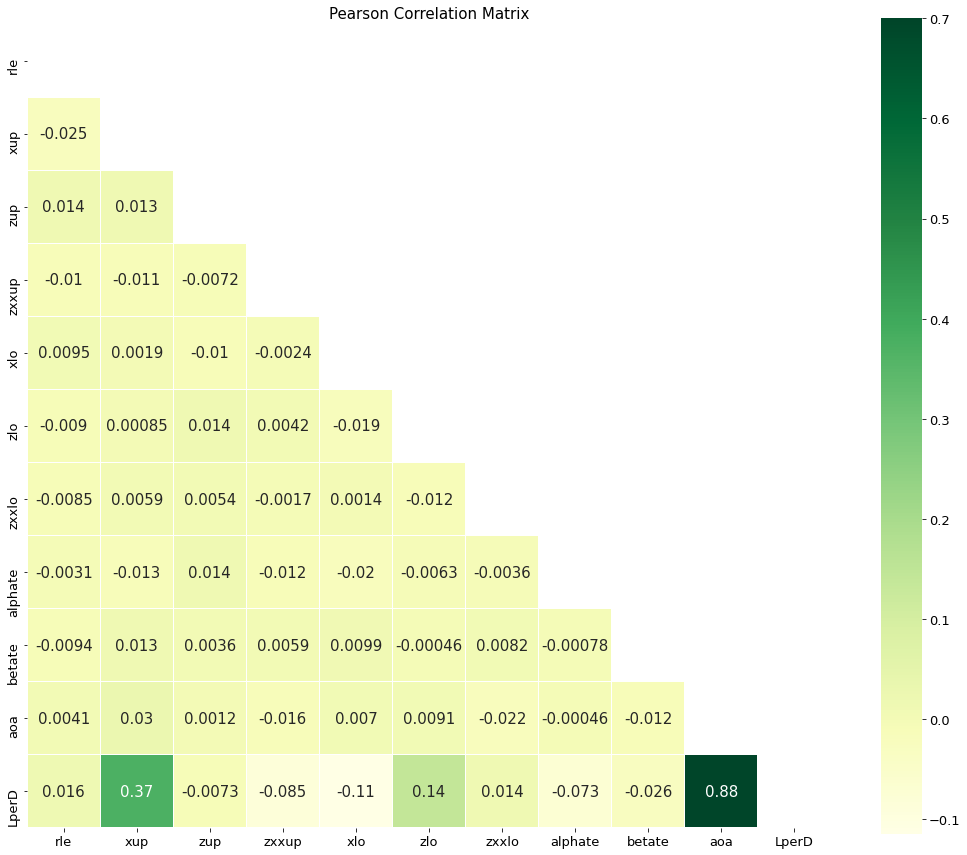

In [ ]:
#@title Pearson Correlation Coefficient (r)
features = ['rle','xup','zup','zxxup','xlo','zlo','zxxlo','alphate','betate','aoa','LperD']
mask = np.zeros_like(data2[features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 15))
plt.title('Pearson Correlation Matrix', fontsize=15)

sns.heatmap(data2[features].corr(), linewidths=0.25, vmax=0.7, square=True, cmap="YlGn",
            linecolor='w', annot=True, annot_kws={'size':15}, mask=mask)

In [ ]:
#@title Visualize the data with scatter plot
#This procedure can only be conducted if the number of variables are 1/2
#Function to create scatter plot of the data
def datascatterplot(X,y):
  n_var = X.shape[1]
  if n_var == 1: #Procedure for one variable
      fig = plt.figure(figsize=[8,6])
      plt.scatter(X,y,color='tab:orange')
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.xlabel('x',fontsize=14)
      plt.ylabel('y',fontsize=14)
      plt.grid()
      plt.show()
  elif n_var == 2: #Procedure for two variables
      fig = plt.figure(figsize=[8,6])
      ax = plt.axes(projection='3d')
      ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange')
      ax.set_xlabel('x1',fontsize=14)
      ax.xaxis.labelpad = 10
      ax.set_ylabel('x2',fontsize=14)
      ax.yaxis.labelpad = 10
      ax.set_zlabel('y',fontsize=14)
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.show()
  else:
      print("Your data has more than two variables")

In [ ]:
datascatterplot(X2,y2)

Your data has more than two variables


In [ ]:
#@title Linear Regression Model
#Function to train a linear regression model on the data. This function will provede regression coefficeints (beta) and its variances (beta_var).
def LinearRegression(X,y):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X

    #Procedure to obtain regression coefficients by minimizing RSS error
    beta = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@y #Procedure to minimize RSS error
    #Procedure to obtain variances from the regression coefficients
    y_hat = F@beta #Predictions at X
    res_sqr = np.power((y-y_hat),2) #Calculate RSS of the trained linear regression model
    sig_hat_sqr = np.sum(res_sqr)/(n_entries-n_var-1) #Estimate sigma squared
    beta_var = (np.linalg.inv(np.transpose(F)@F)*sig_hat_sqr).diagonal() #Calculate variance of each regression coefficient
    beta_var = beta_var.reshape(-1,1)
    return beta,beta_var

In [ ]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta2, beta_var2 = LinearRegression(X2,y2)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var2+1):
    print('beta_{} = {:.4f}'.format(i,beta2[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = 43.1173
beta_1 = 309.7154
beta_2 = 153.1421
beta_3 = -28.4718
beta_4 = -17.4696
beta_5 = -53.9253
beta_6 = 422.9390
beta_7 = 15.6478
beta_8 = -67.3316
beta_9 = -24.0698
beta_10 = 15.8894


In [ ]:
#@title Summary Matrix
#Function to construct a summary matrix
def summarymat(beta, beta_var, n_entries):
    n_var = beta.shape[0]-1
    beta_std = np.power(beta_var,0.5)
    summary = np.zeros((n_var+1,5))
    summary[:,0] = beta[:,0] #Regression coefficients
    summary[:,1] = beta_std[:,0] #Standard deviation of the regression coefficients
    summary[:,2] = np.divide(beta[:,0],beta_std[:,0]) #t-statistic
    df = n_entries-2 #Degree of freedom
    summary[:,3] = ((np.ones((summary.shape[0],1))-stats.t.cdf(np.abs(summary[:,2]),df).reshape(-1,1)).reshape(-1,))*2 #Calculate p-value based on t-statistic
    #Hypothesis test for 95% confidence interval
    for i in range(n_var+1):
        if summary[i,3]<= 0.05: #If p <= 0.05
            summary[i,4] = 1
        else: #If p > 0.05
            summary[i,4] = 0
    return summary

In [ ]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary2 = summarymat(beta2,beta_var2,n_entries2)
print("Summary matrix: ")
print(pd.DataFrame(summary2,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
          Beta  Standard Deviation  t-statistic       p-value  Hypothesis Test
0    43.117284            1.508064    28.591154  0.000000e+00              1.0
1   309.715434           37.453823     8.269261  2.220446e-16              1.0
2   153.142088            1.228902   124.616964  0.000000e+00              1.0
3   -28.471779            4.984063    -5.712564  1.152746e-08              1.0
4   -17.469553            0.698894   -24.995992  0.000000e+00              1.0
5   -53.925280            1.242325   -43.406756  0.000000e+00              1.0
6   422.939036            8.815565    47.976396  0.000000e+00              1.0
7    15.647751            1.315651    11.893540  0.000000e+00              1.0
8   -67.331622            2.661018   -25.302956  0.000000e+00              1.0
9   -24.069846            3.614166    -6.659862  2.921996e-11              1.0
10   15.889425            0.050905   312.139204  0.000000e+00              1.0


In [ ]:
#@title R2 and RSE
#Calculates the accuracy of the linear regression model in R2 error
#Function to calculates R2 error
def R2_comp(X,y,beta):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X

    #Calculate TSS (Total sum of squares)
    TSS = np.sum(np.power((y-np.mean(y)),2))
    #Calculate RSS (Residual sum of squares)
    y_hat = F@beta #Predictions at each X
    RSS = np.sum(np.power((y-y_hat),2))
    #Calculate R2
    R2 = (TSS-RSS)/TSS
    #Calculate RSE
    RSE = np.sqrt((1/(n_entries-2))*RSS)
    return R2,RSE

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_2, RSE2 = R2_comp(X2,y2,beta2)
print("R2-score with the best model: {}".format(R2_2))
print("RSE-score with the best model: {}".format(RSE2))

R2-score with the best model: 0.938350441006534
RSE-score with the best model: 5.229435075201457


In [ ]:
#@title Visualize the trained linear regression model

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplot(beta,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21))
        x1_vec = x1.reshape(-1,)
        x2_vec = x2.reshape(-1,)
        F_temp = np.ones((21*21,3))
        F_temp[:,1] = x1_vec
        F_temp[:,2] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = F_temp@beta
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix

        fig = plt.figure(figsize=[8,6])
        ax = fig.gca(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='Linear Regression Model')
        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        ax.set_xlabel('x1',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('x2',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('y',fontsize=14)
        plt.title('Linear Regression Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()

    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        F_temp = np.ones((21,2))
        F_temp[:,1] = x1
        #Calculates predictions at the prediction locations
        y_hat = np.matmul(F_temp,beta)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='Linear Regression Model')
        plt.title('Linear Regression Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

In [ ]:
#To visualize the trained linear regression model, call modelplot function, input: beta,X,y,x1range,x2range
modelplot(beta2,X2,y2)

Your data has more than two variables


In [ ]:
#@title KNN plotting and prediction

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplotKNN(knn,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21))

        x1n, x2n = np.meshgrid(np.linspace(0,1,21),np.linspace(0,1,21))
        x1_vec = x1n.reshape(-1,); x2_vec = x2n.reshape(-1,)
        X_temp = np.ones((21*21,2)); X_temp[:,0] = x1_vec; X_temp[:,1] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = knn.predict(X_temp)
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix

        fig = plt.figure(figsize=[8,6])
        ax = fig.gca(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='KNN Model')
        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        ax.set_xlabel('x1',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('x2',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('y',fontsize=14)
        plt.title('KNN Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()

    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        x1n = np.linspace(0,1,21)
        X_temp = np.ones((21,1)); X_temp[:,0] = x1n
        #Calculates predictions at the prediction locations
        y_hat = knn.predict(X_temp)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='KNN Model')
        plt.title('KNN Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

In [ ]:
n_neighbors2 = 30 # Number of neighbors

min_max_scaler2 = preprocessing.MinMaxScaler()
X2_norm = min_max_scaler2.fit_transform(X2)
knn2 = neighbors.KNeighborsRegressor(n_neighbors2)
knn2.fit(X2_norm, y2)

modelplotKNN(knn2,X2,y2)
print('R2 =', knn2.score(X2_norm,y2))

Your data has more than two variables
R2 = 0.9034793133714923


## Model Testing

In [ ]:
#@title Import data
data2_test = pd.read_csv('/content/dataset/data_set_aerospace/subsonic_airfoil_data_set_test.csv',index_col='Unnamed: 0')
data2_test.head()

rle       xup       zup  ...    betate     aoa       LperD
8001  0.014951  0.464975  0.093427  ...  0.122884  3.6586  148.220641
8002  0.015647  0.456098  0.108906  ...  0.128741  1.4174  123.398576
8003  0.014709  0.401730  0.109126  ...  0.164996  2.0254  128.073248
8004  0.014679  0.353930  0.104757  ...  0.167230  3.3430  132.700422
8005  0.012437  0.405657  0.119094  ...  0.122290  0.9694  111.937086

[5 rows x 11 columns]

In [ ]:
#@title Data Manipulation
data2_test_array = data2_test.to_numpy()
n_entries2_test = data2_test_array.shape[0]
n_var2_test = data2_test_array.shape[1]-1
print("Five first rows of the data: ")
print(data2_test_array[:5])

Five first rows of the data: 
[[ 1.49507100e-02  4.64974750e-01  9.34265200e-02 -7.95223500e-01
   4.86492250e-01 -6.05417500e-02  3.57303100e-01 -1.59322600e-01
   1.22883600e-01  3.65860000e+00  1.48220641e+02]
 [ 1.56473100e-02  4.56097750e-01  1.08906040e-01 -6.52398500e-01
   4.21862750e-01 -5.04539500e-02  3.61291700e-01 -1.86477400e-01
   1.28741200e-01  1.41740000e+00  1.23398576e+02]
 [ 1.47093300e-02  4.01730250e-01  1.09126360e-01 -6.63592500e-01
   3.38520850e-01 -4.82597500e-02  4.06783300e-01 -1.57103400e-01
   1.64995600e-01  2.02540000e+00  1.28073248e+02]
 [ 1.46785500e-02  3.53929750e-01  1.04756680e-01 -6.37028500e-01
   3.73973350e-01 -5.28459500e-02  4.48625100e-01 -1.70684600e-01
   1.67230000e-01  3.34300000e+00  1.32700422e+02]
 [ 1.24370100e-02  4.05657250e-01  1.19093800e-01 -8.46321500e-01
   3.49865650e-01 -5.55921500e-02  3.87348500e-01 -1.89616200e-01
   1.22290000e-01  9.69400000e-01  1.11937086e+02]]


In [ ]:
X2_test = data2_test_array[:,0:-1]
y2_test = data2_test_array[:,-1].reshape(-1,1)
print("Five first rows of X: ")
print(X2_test[:5])
print("Five first rows of y: ")
print(y2_test[:5].reshape(-1,1))

Five first rows of X: 
[[ 0.01495071  0.46497475  0.09342652 -0.7952235   0.48649225 -0.06054175
   0.3573031  -0.1593226   0.1228836   3.6586    ]
 [ 0.01564731  0.45609775  0.10890604 -0.6523985   0.42186275 -0.05045395
   0.3612917  -0.1864774   0.1287412   1.4174    ]
 [ 0.01470933  0.40173025  0.10912636 -0.6635925   0.33852085 -0.04825975
   0.4067833  -0.1571034   0.1649956   2.0254    ]
 [ 0.01467855  0.35392975  0.10475668 -0.6370285   0.37397335 -0.05284595
   0.4486251  -0.1706846   0.16723     3.343     ]
 [ 0.01243701  0.40565725  0.1190938  -0.8463215   0.34986565 -0.05559215
   0.3873485  -0.1896162   0.12229     0.9694    ]]
Five first rows of y: 
[[148.2206406]
 [123.3985765]
 [128.0732484]
 [132.7004219]
 [111.9370861]]


In [ ]:
#@title Linear R2 and RSE
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_2_test, RSE2_test = R2_comp(X2_test,y2_test,beta2)
print("R2-score with the test data: {}".format(R2_2_test))
print("RSE-score with the test data: {}".format(RSE2_test))

R2-score with the test data: 0.9328060067184641
RSE-score with the test data: 5.532432459015821


In [ ]:
#@title KNN R2
X2_test_norm = min_max_scaler2.fit_transform(X2_test)
print('R2 =', knn2.score(X2_test_norm,y2_test))

R2 = 0.8914836780017369


## Normalized Beta

In [ ]:
X2_norm

array([[0.9169917 , 0.63522705, 0.88038804, ..., 0.04141242, 0.3160316 ,
        0.94669467],
       [0.79867987, 0.63182637, 0.40004   , ..., 0.83625088, 0.80868087,
        0.28052805],
       [0.40624062, 0.04660932, 0.84338434, ..., 0.94398319, 0.99419942,
        0.8839884 ],
       ...,
       [0.45744574, 0.30256051, 0.42024202, ..., 0.06762029, 0.08640864,
        0.59285929],
       [0.04640464, 0.23374675, 0.15371537, ..., 0.17135141, 0.01860186,
        0.59535954],
       [0.22422242, 0.16503301, 0.50215022, ..., 0.86015805, 0.71147115,
        0.9849985 ]])

In [ ]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta2_norm, beta_var2_norm = LinearRegression(X2_norm,y2)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var2+1):
    print('beta_{} = {:.4f}'.format(i,beta2_norm[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = 80.2953
beta_1 = 1.6723
beta_2 = 25.2634
beta_3 = -1.1615
beta_4 = -5.0657
beta_5 = -8.7889
beta_6 = 9.7266
beta_7 = 2.4090
beta_8 = -5.1157
beta_9 = -1.3478
beta_10 = 63.5513


In [ ]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary2_norm = summarymat(beta2_norm,beta_var2_norm,n_entries2)
print("Summary matrix: ")
print(pd.DataFrame(summary2_norm,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
         Beta  Standard Deviation  t-statistic       p-value  Hypothesis Test
0   80.295332            0.327922   244.860701  0.000000e+00              1.0
1    1.672296            0.202230     8.269261  2.220446e-16              1.0
2   25.263391            0.202728   124.616964  0.000000e+00              1.0
3   -1.161532            0.203329    -5.712564  1.152746e-08              1.0
4   -5.065664            0.202659   -24.995992  0.000000e+00              1.0
5   -8.788942            0.202479   -43.406756  0.000000e+00              1.0
6    9.726625            0.202738    47.976396  0.000000e+00              1.0
7    2.409031            0.202550    11.893540  0.000000e+00              1.0
8   -5.115668            0.202177   -25.302956  0.000000e+00              1.0
9   -1.347777            0.202373    -6.659862  2.921996e-11              1.0
10  63.551342            0.203599   312.139204  0.000000e+00              1.0


## Summary

In [ ]:
#@title R2
R2_dict_2 = {'Method': ['Linear Regression', 'KNN'],
        'Train_Data_R2': [R2_2, knn2.score(X2_norm,y2)],
        'Test_Data_R2': [R2_2_test, knn2.score(X2_test_norm,y2_test)]}
pd.DataFrame(R2_dict_2)

Method  Train_Data_R2  Test_Data_R2
0  Linear Regression       0.938350      0.932806
1                KNN       0.903479      0.891484

# 3. Aeroelasticity

## Data Split

The given data `'aeroelasticity_data_set.csv'` must be splitted into test and train data for making sure the accuracy of the model.

In [ ]:
#@title Import data
data3 = pd.read_csv('/content/dataset/data_set_aerospace/aeroelasticity_data_set.csv',index_col='Unnamed: 0')
data3.head()

M     Vf        DC
1  0.778  1.696  0.091831
2  0.667  0.533 -0.056686
3  0.750  0.900 -0.006096
4  0.700  1.300 -0.012506
5  0.667  1.216 -0.045172

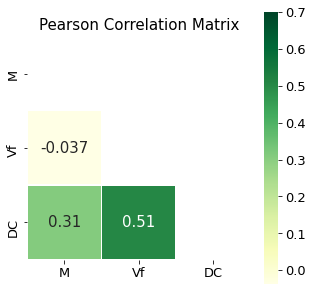

In [ ]:
#@title Pearson Correlation Coefficient (r)
features = ['M','Vf','DC']
mask = np.zeros_like(data3[features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(5, 5))
plt.title('Pearson Correlation Matrix', fontsize=15)

sns.heatmap(data3[features].corr(), linewidths=0.25, vmax=0.7, square=True, cmap="YlGn",
            linecolor='w', annot=True, annot_kws={'size':15}, mask=mask)

In [ ]:
#@title Split the data
data3_train, data3_test = train_test_split(data3, test_size=0.2)
print('train data shape: ' + str(data3_train.shape))
print('test data shape: ' + str(data3_test.shape))

train data shape: (240, 3)
test data shape: (60, 3)


## Model Training

In [ ]:
#@title Data Manipulation
data3_train_array = data3_train.to_numpy()
n_entries3_train = data3_train_array.shape[0]
n_var3_train = data3_train_array.shape[1]-1
print("Five first rows of the data: ")
print(data3_train_array[:5])

Five first rows of the data: 
[[ 7.5000000e-01  1.2000000e+00  1.3311069e-02]
 [ 7.3400000e-01  1.0560000e+00 -1.3236590e-03]
 [ 8.9000000e-01  1.6000000e+00  9.2470350e-03]
 [ 6.3000000e-01  1.2000000e+00 -3.3083362e-02]
 [ 9.0000000e-01  7.0000000e-01 -1.3604030e-03]]


In [ ]:
X3_train = data3_train_array[:,0:-1]
y3_train = data3_train_array[:,-1].reshape(-1,1)
print("Five first rows of X: ")
print(X3_train[:5])
print("Five first rows of y: ")
print(y3_train[:5].reshape(-1,1))

Five first rows of X: 
[[0.75  1.2  ]
 [0.734 1.056]
 [0.89  1.6  ]
 [0.63  1.2  ]
 [0.9   0.7  ]]
Five first rows of y: 
[[ 0.01331107]
 [-0.00132366]
 [ 0.00924704]
 [-0.03308336]
 [-0.0013604 ]]


In [ ]:
#@title Visualize the data with scatter plot
#This procedure can only be conducted if the number of variables are 1/2
#Function to create scatter plot of the data
def datascatterplot(X,y):
  n_var = X.shape[1]
  if n_var == 1: #Procedure for one variable
      fig = plt.figure(figsize=[8,6])
      plt.scatter(X,y,color='tab:orange')
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.xlabel('x',fontsize=14)
      plt.ylabel('y',fontsize=14)
      plt.grid()
      plt.show()
  elif n_var == 2: #Procedure for two variables
      fig = plt.figure(figsize=[8,6])
      ax = plt.axes(projection='3d')
      ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange')
      ax.set_xlabel('M',fontsize=14)
      ax.xaxis.labelpad = 10
      ax.set_ylabel('Vf',fontsize=14)
      ax.yaxis.labelpad = 10
      ax.set_zlabel('DC',fontsize=14)
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.show()
  else:
      print("Your data has more than two variables")

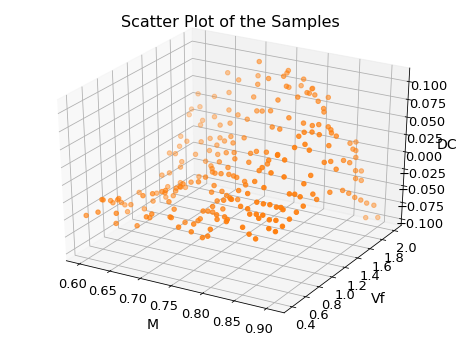

In [ ]:
datascatterplot(X3_train,y3_train)

In [ ]:
#@title Linear Regression Model
#Function to train a linear regression model on the data. This function will provede regression coefficeints (beta) and its variances (beta_var).
def LinearRegression(X,y):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X

    #Procedure to obtain regression coefficients by minimizing RSS error
    beta = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@y #Procedure to minimize RSS error
    #Procedure to obtain variances from the regression coefficients
    y_hat = F@beta #Predictions at X
    res_sqr = np.power((y-y_hat),2) #Calculate RSS of the trained linear regression model
    sig_hat_sqr = np.sum(res_sqr)/(n_entries-n_var-1) #Estimate sigma squared
    beta_var = (np.linalg.inv(np.transpose(F)@F)*sig_hat_sqr).diagonal() #Calculate variance of each regression coefficient
    beta_var = beta_var.reshape(-1,1)
    return beta,beta_var

In [ ]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta3, beta_var3 = LinearRegression(X3_train,y3_train)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var3+1):
    print('beta_{} = {:.4f}'.format(i,beta3[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = -0.1458
beta_1 = 0.1313
beta_2 = 0.0445


In [ ]:
#@title Summary Matrix
#Function to construct a summary matrix
def summarymat(beta, beta_var, n_entries):
    n_var = beta.shape[0]-1
    beta_std = np.power(beta_var,0.5)
    summary = np.zeros((n_var+1,5))
    summary[:,0] = beta[:,0] #Regression coefficients
    summary[:,1] = beta_std[:,0] #Standard deviation of the regression coefficients
    summary[:,2] = np.divide(beta[:,0],beta_std[:,0]) #t-statistic
    df = n_entries-2 #Degree of freedom
    summary[:,3] = ((np.ones((summary.shape[0],1))-stats.t.cdf(np.abs(summary[:,2]),df).reshape(-1,1)).reshape(-1,))*2 #Calculate p-value based on t-statistic
    #Hypothesis test for 95% confidence interval
    for i in range(n_var+1):
        if summary[i,3]<= 0.05: #If p <= 0.05
            summary[i,4] = 1
        else: #If p > 0.05
            summary[i,4] = 0
    return summary

In [ ]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary3 = summarymat(beta3,beta_var3,n_entries3)
print("Summary matrix: ")
print(pd.DataFrame(summary3,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
       Beta  Standard Deviation  t-statistic       p-value  Hypothesis Test
0 -0.145820            0.018460    -7.899407  1.032507e-13              1.0
1  0.131270            0.022707     5.780981  2.318936e-08              1.0
2  0.044455            0.004314    10.303648  0.000000e+00              1.0


In [ ]:
#@title R2 and RSE
#Calculates the accuracy of the linear regression model in R2 error
#Function to calculates R2 error
def R2_comp(X,y,beta):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X

    #Calculate TSS (Total sum of squares)
    TSS = np.sum(np.power((y-np.mean(y)),2))
    #Calculate RSS (Residual sum of squares)
    y_hat = F@beta #Predictions at each X
    RSS = np.sum(np.power((y-y_hat),2))
    #Calculate R2
    R2 = (TSS-RSS)/TSS
    #Calculate RSE
    RSE = np.sqrt((1/(n_entries-2))*RSS)
    return R2,RSE

In [ ]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_3, RSE3 = R2_comp(X3_train,y3_train,beta3)
print("R2-score with the best model: {}".format(R2_3))
print("RSE-score with the best model: {}".format(RSE3))

R2-score with the best model: 0.3607263976106791
RSE-score with the best model: 0.03256583127849422


In [ ]:
#@title Visualize the trained linear regression model

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplot(beta,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21))
        x1_vec = x1.reshape(-1,)
        x2_vec = x2.reshape(-1,)
        F_temp = np.ones((21*21,3))
        F_temp[:,1] = x1_vec
        F_temp[:,2] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = F_temp@beta
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix

        fig = plt.figure(figsize=[8,6])
        ax = fig.gca(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='Linear Regression Model')
        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        ax.set_xlabel('M',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('Vf',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('DC',fontsize=14)
        plt.title('Linear Regression Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()

    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        F_temp = np.ones((21,2))
        F_temp[:,1] = x1
        #Calculates predictions at the prediction locations
        y_hat = np.matmul(F_temp,beta)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='Linear Regression Model')
        plt.title('Linear Regression Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

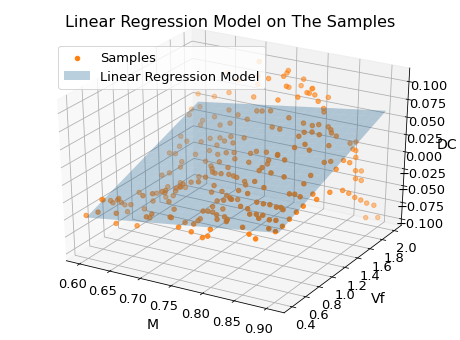

In [ ]:
#To visualize the trained linear regression model, call modelplot function, input: beta,X,y,x1range,x2range
modelplot(beta3,X3_train,y3_train)

In [ ]:
#@title KNN plotting and prediction

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplotKNN(knn,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21))

        x1n, x2n = np.meshgrid(np.linspace(0,1,21),np.linspace(0,1,21))
        x1_vec = x1n.reshape(-1,); x2_vec = x2n.reshape(-1,)
        X_temp = np.ones((21*21,2)); X_temp[:,0] = x1_vec; X_temp[:,1] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = knn.predict(X_temp)
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix

        fig = plt.figure(figsize=[8,6])
        ax = fig.gca(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='KNN Model')
        surf._facecolors2d=surf._facecolors3d
        surf._edgecolors2d=surf._edgecolors3d
        ax.set_xlabel('M',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('Vf',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('DC',fontsize=14)
        plt.title('KNN Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()

    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        x1n = np.linspace(0,1,21)
        X_temp = np.ones((21,1)); X_temp[:,0] = x1n
        #Calculates predictions at the prediction locations
        y_hat = knn.predict(X_temp)

        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='KNN Model')
        plt.title('KNN Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

In [ ]:
n_neighbors3 = 15 # Number of neighbors

min_max_scaler3 = preprocessing.MinMaxScaler()
X3_train_norm = min_max_scaler3.fit_transform(X3_train)
knn3 = neighbors.KNeighborsRegressor(n_neighbors3)
knn3.fit(X3_train_norm, y3_train)

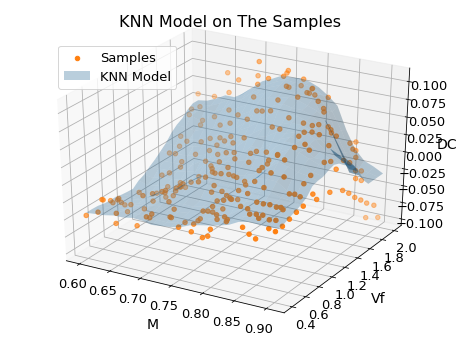

R2 = 0.8867785465401631


In [ ]:
modelplotKNN(knn3,X3_train,y3_train)
print('R2 =', knn3.score(X3_train_norm,y3_train))

## Model Testing

In [ ]:
#@title Data Manipulation
data3_test_array = data3_test.to_numpy()
n_entries3_test = data3_test_array.shape[0]
n_var2_test = data3_test_array.shape[1]-1
print("Five first rows of the data: ")
print(data3_test_array[:5])

Five first rows of the data: 
[[ 0.73        0.832      -0.01142291]
 [ 0.6         1.4        -0.02205894]
 [ 0.7         1.2        -0.01068058]
 [ 0.635       1.728       0.00487789]
 [ 0.7         1.1        -0.01689907]]


In [ ]:
X3_test = data3_test_array[:,0:-1]
y3_test = data3_test_array[:,-1].reshape(-1,1)
print("Five first rows of X: ")
print(X3_test[:5])
print("Five first rows of y: ")
print(y3_test[:5].reshape(-1,1))

Five first rows of X: 
[[0.73  0.832]
 [0.6   1.4  ]
 [0.7   1.2  ]
 [0.635 1.728]
 [0.7   1.1  ]]
Five first rows of y: 
[[-0.01142291]
 [-0.02205894]
 [-0.01068058]
 [ 0.00487789]
 [-0.01689907]]


In [ ]:
#@title Linear R2 and RSE
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2_3_test, RSE3_test = R2_comp(X3_test,y3_test,beta3)
print("R2-score with the test data: {}".format(R2_3_test))
print("RSE-score with the test data: {}".format(RSE3_test))

R2-score with the test data: 0.38015506922854786
RSE-score with the test data: 0.029614615549358736


In [ ]:
#@title KNN R2
X3_test_norm = min_max_scaler3.fit_transform(X3_test)
print('R2 =', knn3.score(X3_test_norm,y3_test))

R2 = 0.8508006234184213


## Summary

In [ ]:
#@title R2
R2_dict_3 = {'Method': ['Linear Regression', 'KNN'],
        'Train_Data_R2': [R2_3, knn3.score(X3_train_norm,y3_train)],
        'Test_Data_R2': [R2_3_test, knn3.score(X3_test_norm,y3_test)]}
pd.DataFrame(R2_dict_3)

Method  Train_Data_R2  Test_Data_R2
0  Linear Regression       0.360726      0.380155
1                KNN       0.886779      0.850801

## Flutter Boundary

In [ ]:
flutter_label = []
flutter_bool = []
for i in range(len(data3)):
  if data3.iloc[i]['DC'] > 0:
    flutter_label.append('unstable')
    flutter_bool.append(1)
  else:
    flutter_label.append('stable')
    flutter_bool.append(0)
data3['flutter'] = flutter_label
data3['flutter_bool'] = flutter_bool
data3.head()

M     Vf        DC   flutter  flutter_bool
1  0.778  1.696  0.091831  unstable             1
2  0.667  0.533 -0.056686    stable             0
3  0.750  0.900 -0.006096    stable             0
4  0.700  1.300 -0.012506    stable             0
5  0.667  1.216 -0.045172    stable             0

In [ ]:
#@title Visualize the data with scatter plot
#Function to create scatter plot of the data
def datascatterplot(df):
    fig = px.scatter_3d(df, x='M', y='Vf', z='DC', color='flutter',
                        width=1000, height=750)
    fig.show()
datascatterplot(data3)

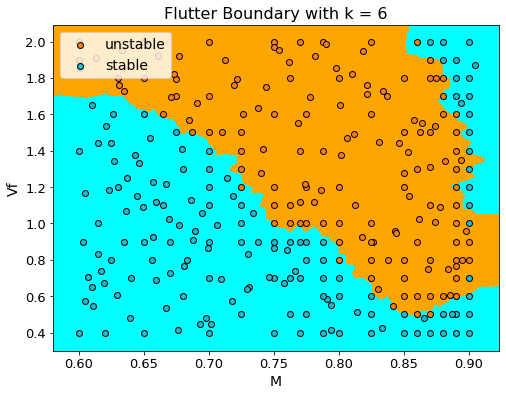

R2 KNN = 0.9633333333333334


In [ ]:
#@title Visualization of Flutter Boundary with KNN

k = 6 #@param {type: "slider", min: 1, max: 30}

def boundary(knn,X,y):
  min_max_scaler = preprocessing.MinMaxScaler()
  #Create the location of X to visualize
  x_min, x_max = X[:,0].min()-0.020, X[:,0].max()+0.020
  y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1

  hx = (x_max-x_min)/250
  hy = (y_max-y_min)/250
  #Calculate prediction at each prediction location
  xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
  X_norm = np.c_[xx.ravel(), yy.ravel()]
  #Scale X for KNN model
  scaler_X = min_max_scaler.fit(X)
  X_norm = scaler_X.transform(X_norm)
  Z = knn.predict(X_norm)

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(1, figsize=(8, 6))
  cMap = c.ListedColormap(['cyan','orange'])
  plt.pcolormesh(xx, yy, Z, cmap=cMap)
  pos = np.where(y==1) #To find which row(s) that have y=1
  neg = np.where(y==0) #To find which row(s) that have y=0
  plt.scatter(X[pos,0],X[pos,1],label='unstable',c='tab:orange',edgecolors='k')
  plt.scatter(X[neg,0],X[neg,1],label='stable',c='tab:cyan',edgecolors='k')
  plt.xlabel('M', fontsize=14)
  plt.ylabel('Vf', fontsize=14)
  plt.title('Flutter Boundary with k = ' + str(k),fontsize=16)
  plt.legend(fontsize=14)
  plt.show()

def knn_comparison(data, k):
  x = data[['M','Vf']].values
  y = data['flutter_bool'].values
  min_max_scaler = preprocessing.MinMaxScaler()
  x_norm = min_max_scaler.fit_transform(x)
  clf = neighbors.KNeighborsClassifier(n_neighbors=k)
  clf.fit(x_norm, y)

  boundary(clf, x, y)
  print('R2 KNN =',clf.score(x_norm, y))

#Visualize the kNN classification model
knn_comparison(data3, k)

# 4. Aviation

## Flight Data Preparation

Before we import and process the data, let's check the CPU thread count.

In [ ]:
cpu_count()

2

As you can see, the CPU only has 2 threads.

Next, make 2 lists for the flight data's file name and path.

In [ ]:
time_benchmark_predict = 0
time_benchmark_validation = 0

In [ ]:
%%time
start = time.time()

path = '/content/dataset/flight-data/'
file_path = [path+f for f in listdir(path) if isfile(join(path, f))]
file_path.sort()
filename = [f.split('.')[0] for f in listdir(path) if isfile(join(path, f))]
filename.sort()

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 4.92 ms, sys: 5.01 ms, total: 9.93 ms
Wall time: 11.2 ms


In [ ]:
file_path[0:5]

['/content/dataset/flight-data/flight_10009.zip',
 '/content/dataset/flight-data/flight_10013.zip',
 '/content/dataset/flight-data/flight_10043.zip',
 '/content/dataset/flight-data/flight_10049.zip',
 '/content/dataset/flight-data/flight_10057.zip']

In [ ]:
filename[0:5]

['flight_10009',
 'flight_10013',
 'flight_10043',
 'flight_10049',
 'flight_10057']

Import all data into list of dataframe

In [ ]:
%%time
start = time.time()

thread_count = 2 #@param {type: "slider", min: 1, max: 16}
pool = ThreadPool(thread_count)
data4_list = pool.map(pd.read_csv, file_path)

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 16.1 s, sys: 1.02 s, total: 17.1 s
Wall time: 9.45 s


In [ ]:
data4_list[0:2]

[      time_s   hbaro_m  hdot_1_mps  hralt_m  ...  gs_mps  wow   chi_rad  flap_te_pos
 0        0.0   64.9224     0.08128  -0.2286  ...     0.0  0.0  1.972450        0.116
 1        1.0   64.3128    -0.40640  -0.1143  ...     0.0  NaN  1.944072          NaN
 2        2.0   64.6176    -0.16256  -0.1524  ...     0.0  0.0  1.924131        0.116
 3        3.0   64.6176     0.08128  -0.1524  ...     0.0  NaN  1.903710          NaN
 4        4.0   64.9224     0.40640  -0.0762  ...     0.0  0.0  1.879455        0.116
 ...      ...       ...         ...      ...  ...     ...  ...       ...          ...
 7051  7051.0  344.7288     0.08128  -0.0381  ...     0.0  NaN  0.000000          NaN
 7052  7052.0  345.0336     0.16256  -0.0762  ...     0.0  0.0  0.000000        0.115
 7053  7053.0  344.4240    -0.32512  -0.0381  ...     0.0  NaN  0.000000          NaN
 7054  7054.0  344.7288    -0.24384  -0.0381  ...     0.0  0.0  0.000000        0.115
 7055  7055.0  345.3384     0.24384  -0.0381  ...     

In [ ]:
len(data4_list)

500

There are 500 flight data that have been imported.

Next, make dictionary of the data for convenient indexing.

In [ ]:
%%time
start = time.time()

data4_dict = dict(zip(filename, data4_list))

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 4.98 ms, sys: 11.1 ms, total: 16.1 ms
Wall time: 16.6 ms


In [ ]:
print(filename[0])
data4_dict[filename[0]]

flight_10009


time_s   hbaro_m  hdot_1_mps  hralt_m  ...  gs_mps  wow   chi_rad  flap_te_pos
0        0.0   64.9224     0.08128  -0.2286  ...     0.0  0.0  1.972450        0.116
1        1.0   64.3128    -0.40640  -0.1143  ...     0.0  NaN  1.944072          NaN
2        2.0   64.6176    -0.16256  -0.1524  ...     0.0  0.0  1.924131        0.116
3        3.0   64.6176     0.08128  -0.1524  ...     0.0  NaN  1.903710          NaN
4        4.0   64.9224     0.40640  -0.0762  ...     0.0  0.0  1.879455        0.116
...      ...       ...         ...      ...  ...     ...  ...       ...          ...
7051  7051.0  344.7288     0.08128  -0.0381  ...     0.0  NaN  0.000000          NaN
7052  7052.0  345.0336     0.16256  -0.0762  ...     0.0  0.0  0.000000        0.115
7053  7053.0  344.4240    -0.32512  -0.0381  ...     0.0  NaN  0.000000          NaN
7054  7054.0  344.7288    -0.24384  -0.0381  ...     0.0  0.0  0.000000        0.115
7055  7055.0  345.3384     0.24384  -0.0381  ...     0.0  NaN  0.000000          NaN

[7056 rows x 11 columns]

Filter the data from outliers and NaN values

In [ ]:
%%time
start = time.time()

flight_path_dict = {}
for i in filename:
  temp = data4_dict[i]
  temp.fillna(method='ffill', inplace=True)
  z_scores = stats.zscore(temp[['lon_rad','lat_rad']])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < 3).all(axis=1)
  temp = temp[filtered_entries]
  flight_path_dict[i] = temp

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 1.22 s, sys: 42.3 ms, total: 1.26 s
Wall time: 1.26 s


In [ ]:
flight_path_dict[filename[0]]

time_s   hbaro_m  hdot_1_mps  hralt_m  ...  gs_mps  wow   chi_rad  flap_te_pos
0        0.0   64.9224     0.08128  -0.2286  ...     0.0  0.0  1.972450        0.116
1        1.0   64.3128    -0.40640  -0.1143  ...     0.0  0.0  1.944072        0.116
2        2.0   64.6176    -0.16256  -0.1524  ...     0.0  0.0  1.924131        0.116
3        3.0   64.6176     0.08128  -0.1524  ...     0.0  0.0  1.903710        0.116
4        4.0   64.9224     0.40640  -0.0762  ...     0.0  0.0  1.879455        0.116
...      ...       ...         ...      ...  ...     ...  ...       ...          ...
6805  6805.0  345.3384    -0.32512   0.1143  ...     0.0  0.0 -2.962413        0.116
6806  6806.0  345.3384     0.00000   0.1143  ...     0.0  0.0 -2.957428        0.116
6807  6807.0  345.3384     0.08128   0.1143  ...     0.0  0.0 -2.977273        0.116
6808  6808.0  345.3384     0.00000   0.1143  ...     0.0  0.0 -2.964427        0.116
6809  6809.0  345.3384    -0.08128   0.1143  ...     0.0  0.0 -2.959249        0.116

[6810 rows x 11 columns]

Separate the longitude and latitude position data

In [ ]:
%%time
start = time.time()

flight_path_lon_deg_dict = {}
flight_path_lat_deg_dict = {}
departure_lon_deg_dict = {}
departure_lat_deg_dict = {}
arrival_lon_deg_dict = {}
arrival_lat_deg_dict = {}
for i in filename:
  temp = flight_path_dict[i]
  flight_path_lon_deg_dict[i] = temp['lon_rad'].to_numpy()*180/pi
  flight_path_lat_deg_dict[i] = temp['lat_rad'].to_numpy()*180/pi
  departure_lon_deg_dict[i] = temp['lon_rad'].iloc[0]*180/pi
  departure_lat_deg_dict[i] = temp['lat_rad'].iloc[0]*180/pi
  arrival_lon_deg_dict[i] = temp['lon_rad'].iloc[-1]*180/pi
  arrival_lat_deg_dict[i] = temp['lat_rad'].iloc[-1]*180/pi

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 132 ms, sys: 14 ms, total: 146 ms
Wall time: 147 ms


In [ ]:
print(flight_path_lon_deg_dict[filename[0]][:5])
print(flight_path_lon_deg_dict[filename[0]][-6:-1])
print(departure_lon_deg_dict[filename[0]])
print(arrival_lon_deg_dict[filename[0]])

[-89.9782491 -89.9782491 -89.9782491 -89.9782491 -89.9782491]
[-94.29725939 -94.29725939 -94.29725939 -94.29725939 -94.29725939]
-89.9782491003143
-94.29725939111556


In [ ]:
print(flight_path_lat_deg_dict[filename[0]][:5])
print(flight_path_lat_deg_dict[filename[0]][-6:-1])
print(departure_lat_deg_dict[filename[0]])
print(arrival_lat_deg_dict[filename[0]])

[35.0426276 35.0426276 35.0426276 35.0426276 35.0426276]
[36.27669947 36.27669947 36.27669947 36.27669947 36.27669947]
35.04262759899398
36.276699469377256


Merge the longitude and latitude position data into list of array

In [ ]:
%%time
start = time.time()

flight_path_lat_lon_deg_dict = {}
for i in filename:
  temp = flight_path_lat_deg_dict[i]
  temp2 = flight_path_lon_deg_dict[i]
  flight_path_lat_lon_deg_dict[i] = list(zip(temp, temp2))

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 1.06 s, sys: 366 ms, total: 1.43 s
Wall time: 1.45 s


In [ ]:
flight_path_lat_lon_deg_dict[filename[0]][:5]

[(35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143)]

In [ ]:
%%time
start = time.time()

flight_path_lat_lon_deg = list(flight_path_lat_lon_deg_dict.values())

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 994 ms, sys: 60.1 ms, total: 1.05 s
Wall time: 1.05 s


In [ ]:
flight_path_lat_lon_deg[0][:5]

[(35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143),
 (35.04262759899398, -89.9782491003143)]

## Airport/Flight Departure & Arrival Point Visualization

In [ ]:
%%time

#@title Visualization in Google Maps

f_Map = folium.Figure(width=1000, height=500)
Map = folium.Map(location=[40, -97], zoom_start=4).add_to(f_Map)

# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True
    )
}

# Add custom basemaps
basemaps['Google Satellite Hybrid'].add_to(Map)
basemaps['Google Maps'].add_to(Map)

# Add a layer control panel to the map.
Map.add_child(folium.LayerControl())

# mouse position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:",lat_formatter=fmtr, lng_formatter=fmtr).add_to(Map)

# Add the draw
plugins.Draw(export=True, filename='data.geojson', position='topleft', draw_options=None, edit_options=None).add_to(Map)

# Add measure tool
plugins.MeasureControl(position='topright', primary_length_unit='meters', secondary_length_unit='miles', primary_area_unit='sqmeters', secondary_area_unit='acres').add_to(Map)

for index in range(len(filename)):
  temp = flight_path_lat_lon_deg[index]

  folium.Marker(location=temp[0],
                     popup="<i>Departure Point</i>",
                     tooltip='Click',
                     icon=folium.Icon(color='green', icon='glyphicon-plane')
                     ).add_to(Map)

  folium.Marker(location=temp[-1],
                     popup="<i>Arrival Point</i>",
                     tooltip='Click',
                     icon=folium.Icon(color='red', icon='glyphicon-plane')
                     ).add_to(Map)

  folium.PolyLine([temp[0], temp[-1]], color="blue", weight=2, opacity=1).add_to(Map)

display(Map)

CPU times: user 3.25 s, sys: 111 ms, total: 3.36 s
Wall time: 3.23 s


## Airport Data Modeling & Prediction

### Preparation

In [ ]:
%%time
start = time.time()

airports = pd.read_csv('/content/drive/MyDrive/dataset/airport/airports.csv')
indexNames = airports[~((airports['type'] == 'small_airport') | (airports['type'] == 'medium_airport') | (airports['type'] == 'large_airport'))].index
airports.drop(indexNames , inplace=True)
airports.drop_duplicates(subset=['latitude_deg','longitude_deg'], inplace=True)
airports.reset_index(drop=True, inplace=True)

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 305 ms, sys: 7.23 ms, total: 312 ms
Wall time: 328 ms


In [ ]:
airports

id  ...              keywords
0      323361  ...                   NaN
1        6524  ...                   NaN
2        6525  ...                   NaN
3      322127  ...                   NaN
4        6527  ...                   NaN
...       ...  ...                   ...
41449   27244  ...                   NaN
41450  317861  ...                   NaN
41451   32753  ...                   NaN
41452  307326  ...                   NaN
41453  313629  ...  SATSUMA,IWOJIMA,RJX7

[41454 rows x 18 columns]

### Modeling

In [ ]:
%%time
start = time.time()

X_airport = airports[[ 'latitude_deg', 'longitude_deg']]
y_airport_ident = airports['ident']
y_airport_name = airports['name']
n_neighbors = 1
knn_airport_ident = neighbors.KNeighborsClassifier(n_neighbors)
knn_airport_name = neighbors.KNeighborsClassifier(n_neighbors)
knn_airport_ident.fit(X_airport,y_airport_ident)
knn_airport_name.fit(X_airport,y_airport_name)

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 184 ms, sys: 1.57 ms, total: 185 ms
Wall time: 187 ms


In [ ]:
knn_airport_ident.score(X_airport,y_airport_ident)

1.0

### Prediction

In [ ]:
%%time
start = time.time()

departure_df = pd.DataFrame({'latitude_deg':departure_lat_deg_dict.values(), 'longitude_deg':departure_lon_deg_dict.values()})
arrival_df = pd.DataFrame({ 'latitude_deg':arrival_lat_deg_dict.values(), 'longitude_deg':arrival_lon_deg_dict.values()})
departure_arrival_airport = pd.DataFrame({'flight_data':filename,
                                          'departure_airport_icao':knn_airport_ident.predict(departure_df),
                                          'departure_airport_name':knn_airport_name.predict(departure_df),
                                          'arrival_airport_icao':knn_airport_ident.predict(arrival_df),
                                          'arrival_airport_name':knn_airport_name.predict(arrival_df)})

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 60.8 ms, sys: 0 ns, total: 60.8 ms
Wall time: 60.9 ms


In [ ]:
departure_arrival_airport

flight_data  ...                               arrival_airport_name
0    flight_10009  ...                Northwest Arkansas Regional Airport
1    flight_10013  ...               Springfield Branson National Airport
2    flight_10043  ...                         Westchester County Airport
3    flight_10049  ...                   Des Moines International Airport
4    flight_10057  ...                                    Eppley Airfield
..            ...  ...                                                ...
495  flight_50440  ...          Detroit Metropolitan Wayne County Airport
496  flight_51000  ...  Minneapolis–Saint Paul International Airport /...
497  flight_51054  ...                      Memphis International Airport
498  flight_51056  ...                      Memphis International Airport
499  flight_59785  ...  Minneapolis–Saint Paul International Airport /...

[500 rows x 5 columns]

## Runway Data Prediction

### Preparation

In [ ]:
%%time
start = time.time()

runways = pd.read_csv('/content/drive/MyDrive/dataset/airport/runways.csv')
indexNames = runways[runways['he_ident'].isna()].index
runways.drop(indexNames , inplace=True)
runways.reset_index(drop=True, inplace=True)

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 84.7 ms, sys: 6.93 ms, total: 91.6 ms
Wall time: 101 ms


In [ ]:
runways

id  airport_ref  ... he_heading_degT  he_displaced_threshold_ft
0      255155         6524  ...             NaN                        NaN
1      254165         6525  ...             NaN                        NaN
2      270932         6526  ...             NaN                        NaN
3      322128       322127  ...             NaN                        NaN
4      257681         6527  ...             NaN                        NaN
...       ...          ...  ...             ...                        ...
35854  327703       327451  ...             NaN                        NaN
35855  235188        27242  ...           275.6                      320.0
35856  235186        27243  ...           229.0                        NaN
35857  235169        27244  ...           261.7                        NaN
35858  313663       313629  ...             NaN                        NaN

[35859 rows x 20 columns]

### Prediction

In [ ]:
%%time
start = time.time()

departure_runway = {}
arrival_runway = {}
for i in filename:
  temp = flight_path_dict[i]
  temp = temp[temp['wow'] == 1]
  temp['runway'] = np.round(temp['chi_rad'].to_numpy()*180/pi, decimals=-1)/10
  temp['runway'] = temp['runway'].astype(int)
  depart_temp = temp['runway'].iloc[0]
  if depart_temp <= 0:
    depart_temp+=36
    if depart_temp > 18:
      depart_temp2 = depart_temp-18
      departure_runway[i] = (str(depart_temp2)+'-'+str(depart_temp))
    else:
      depart_temp2 = depart_temp+18
      departure_runway[i] = (str(depart_temp)+'-'+str(depart_temp2))
  else:
    if depart_temp > 18:
      depart_temp2 = depart_temp-18
      departure_runway[i] = (str(depart_temp2)+'-'+str(depart_temp))
    else:
      depart_temp2 = depart_temp+18
      departure_runway[i] = (str(depart_temp)+'-'+str(depart_temp2))
  arrival_temp = temp['runway'].iloc[-1]
  if arrival_temp <= 0:
    arrival_temp+=36
    if arrival_temp > 18:
      arrival_temp2 = arrival_temp-18
      arrival_runway[i] = (str(arrival_temp2)+'-'+str(arrival_temp))
    else:
      arrival_temp2 = arrival_temp+18
      arrival_runway[i] = (str(arrival_temp)+'-'+str(arrival_temp2))
  else:
    if arrival_temp > 18:
      arrival_temp2 = arrival_temp-18
      arrival_runway[i] = (str(arrival_temp2)+'-'+str(arrival_temp))
    else:
      arrival_temp2 = arrival_temp+18
      arrival_runway[i] = (str(arrival_temp)+'-'+str(arrival_temp2))
departure_arrival_airport['departure_airport_runway'] = departure_runway.values()
departure_arrival_airport['arrival_airport_runway'] = arrival_runway.values()
departure_arrival_airport.to_csv('/content/results.csv')

end = time.time()
rel_time = end-start
time_benchmark_predict += rel_time

CPU times: user 936 ms, sys: 28.3 ms, total: 964 ms
Wall time: 982 ms


In [ ]:
departure_arrival_airport

flight_data  ... arrival_airport_runway
0    flight_10009  ...                  16-34
1    flight_10013  ...                  14-32
2    flight_10043  ...                  15-33
3    flight_10049  ...                   5-23
4    flight_10057  ...                  18-36
..            ...  ...                    ...
495  flight_50440  ...                   3-21
496  flight_51000  ...                  12-30
497  flight_51054  ...                  18-36
498  flight_51056  ...                  18-36
499  flight_59785  ...                  12-30

[500 rows x 7 columns]

## Flight Data Validation

In [ ]:
%%time
start = time.time()

#@title Visualization per flight data

index = 36 #@param {type: "slider", min: 0, max: 499}
temp = flight_path_lat_lon_deg[index]

f_Map = folium.Figure(width=1000, height=500)
Map = folium.Map(location=[40, -97], zoom_start=4).add_to(f_Map)

# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True
    )
}

# Add custom basemaps
basemaps['Google Satellite Hybrid'].add_to(Map)
basemaps['Google Maps'].add_to(Map)

# Add a layer control panel to the map.
Map.add_child(folium.LayerControl())

# mouse position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:",lat_formatter=fmtr, lng_formatter=fmtr).add_to(Map)

# Add the draw
plugins.Draw(export=True, filename='data.geojson', position='topleft', draw_options=None, edit_options=None).add_to(Map)

# Add measure tool
plugins.MeasureControl(position='topright', primary_length_unit='meters', secondary_length_unit='miles', primary_area_unit='sqmeters', secondary_area_unit='acres').add_to(Map)

folium.Marker(location=temp[0],
                     popup="<i>Departure Point</i>",
                     tooltip='Click',
                     icon=folium.Icon(color='green', icon='glyphicon-plane')
                     ).add_to(Map)

folium.Marker(location=temp[-1],
                     popup="<i>Arrival Point</i>",
                     tooltip='Click',
                     icon=folium.Icon(color='red', icon='glyphicon-plane')
                     ).add_to(Map)

folium.PolyLine(temp, color="blue", weight=5, opacity=1).add_to(Map)

display(Map)

# For validation
print('\nflight data')
display(departure_arrival_airport.loc[index:index])
print('\ndeparture airport runway data')
display(runways[runways['airport_ident']==departure_arrival_airport.loc[index:index].iloc[0]['departure_airport_icao']][['airport_ident','le_ident','he_ident']])
print('\narrival airport runway data')
display(runways[runways['airport_ident']==departure_arrival_airport.loc[index:index].iloc[0]['arrival_airport_icao']][['airport_ident','le_ident','he_ident']])
print('\n')

end = time.time()
rel_time = end-start
time_benchmark_validation += rel_time


flight data


flight_data  ... arrival_airport_runway
36  flight_10488  ...                   4-22

[1 rows x 7 columns]


departure airport runway data


airport_ident le_ident he_ident
17979          KMEM       09       27
17980          KMEM      18C      36C
17981          KMEM      18L      36R
17982          KMEM      18R      36L


arrival airport runway data


airport_ident le_ident he_ident
18640          KORF       05       23
18641          KORF       14       32



CPU times: user 290 ms, sys: 6.66 ms, total: 297 ms
Wall time: 303 ms


### Airport Validation with OpenStreetMap

In [ ]:
%%time
start = time.time()

def search(loc):
  loc += ' Airport US'
  url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(loc) +'?format=json&addressdetails=1&limit=1&polygon_svg=1'
  response = requests.get(url).json()
  return (float(response[0]["lat"]), float(response[0]["lon"]))

departure_airport_pos_deg_dict = {}
key = departure_arrival_airport['departure_airport_icao'].unique()
for i in range(len(key)):
  departure_airport_pos_deg_dict[key[i]] = search(key[i])

arrival_airport_pos_deg_dict = {}
key = departure_arrival_airport['arrival_airport_icao'].unique()
for i in range(len(key)):
  arrival_airport_pos_deg_dict[key[i]] = search(key[i])

end = time.time()
rel_time = end-start
time_benchmark_validation += rel_time

CPU times: user 816 ms, sys: 61.4 ms, total: 877 ms
Wall time: 32.7 s


In [ ]:
departure_airport_pos_deg_dict

{'KDLH': (46.84183845, -92.20329684929376),
 'KDTW': (42.205699100000004, -83.35297537621658),
 'KMEM': (35.04625645, -89.97689466513185),
 'KMSP': (44.878019050000006, -93.2209280537696),
 'KOKC': (35.3848053, -97.60534425082406),
 'KOMA': (41.3011252, -95.88987091468039),
 'KSTL': (38.74957195, -90.37014071044965)}

In [ ]:
arrival_airport_pos_deg_dict

{'CYQR': (50.4309977, -104.66560618608906),
 'CYUL': (45.46873715, -73.74257166095532),
 'CYXE': (52.172371999999996, -106.69161089220799),
 'KATL': (33.63779875, -84.42927118585675),
 'KAUS': (30.19348925, -97.66500963529677),
 'KAZO': (42.2307865, -85.5510419237961),
 'KBGR': (44.8072619, -68.81941486105113),
 'KBHM': (33.5635078, -86.75154126864663),
 'KBNA': (36.11958985, -86.68308703291842),
 'KBTR': (30.5319743, -91.15037753510408),
 'KBTV': (44.472896500000004, -73.15146310750751),
 'KCHS': (32.89929845, -80.03946503050427),
 'KCID': (41.885103799999996, -91.71471001965821),
 'KCLE': (41.406618550000005, -81.85120214358412),
 'KCLT': (35.21074145, -80.9457435226013),
 'KCVG': (39.049907149999996, -84.66516172504984),
 'KDAY': (39.905318699999995, -84.22024542480268),
 'KDFW': (32.89651945, -97.0465220537124),
 'KDLH': (46.84183845, -92.20329684929376),
 'KDSM': (41.534256, -93.65927182349738),
 'KDTW': (42.205699100000004, -83.35297537621658),
 'KEWR': (40.68906405, -74.17725485

In [ ]:
%%time
start = time.time()
bool_depart = {}
bool_arrival = {}

for i in filename:
  temp = departure_arrival_airport[departure_arrival_airport['flight_data']==i]
  bool_depart[i] = (round(departure_airport_pos_deg_dict[temp['departure_airport_icao'].iloc[0]][0]) == round(departure_lat_deg_dict[i])) & (round(departure_airport_pos_deg_dict[temp['departure_airport_icao'].iloc[0]][1]) == round(departure_lon_deg_dict[i]))
  bool_arrival[i] = (round(arrival_airport_pos_deg_dict[temp['arrival_airport_icao'].iloc[0]][0]) == round(arrival_lat_deg_dict[i])) & (round(arrival_airport_pos_deg_dict[temp['arrival_airport_icao'].iloc[0]][1]) == round(arrival_lon_deg_dict[i]))

departure_arrival_airport_validation = departure_arrival_airport[['flight_data']]
departure_arrival_airport_validation['departure_bool'] = bool_depart.values()
departure_arrival_airport_validation['arrival_bool'] = bool_arrival.values()

end = time.time()
rel_time = end-start
time_benchmark_validation += rel_time

CPU times: user 277 ms, sys: 21.6 ms, total: 298 ms
Wall time: 283 ms


In [ ]:
departure_arrival_airport_validation

flight_data  departure_bool  arrival_bool
0    flight_10009            True          True
1    flight_10013            True          True
2    flight_10043            True          True
3    flight_10049            True          True
4    flight_10057            True          True
..            ...             ...           ...
495  flight_50440            True          True
496  flight_51000            True          True
497  flight_51054            True          True
498  flight_51056            True          True
499  flight_59785            True          True

[500 rows x 3 columns]

In [ ]:
departure_arrival_airport_validation.describe()

flight_data departure_bool arrival_bool
count            500            500          500
unique           500              1            1
top     flight_14065           True         True
freq               1            500          500

## Execution Time

In [ ]:
print('Prediction Execution Time:', time_benchmark_predict, 's')
print('Validation Execution Time:', time_benchmark_validation, 's')
print('Total Execution Time:', time_benchmark_predict + time_benchmark_validation, 's')

Prediction Execution Time: 14.149417638778687 s
Validation Execution Time: 33.26383066177368 s
Total Execution Time: 47.41324830055237 s
